In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
from pathlib import Path
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchtext
from torchtext.data.metrics import bleu_score

import timm
import fastai.text.all as fastai
from fastai.callback.schedule import Learner

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
%load_ext tensorboard

import spacy
import re
import nltk

seed = 42
np.random.seed(seed)
torch.manual_seed(seed + 1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed + 2)

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
    return device

device = get_device()

print(f'device: {device}')

device: cuda


In [28]:
model_path = Path.cwd() / 'models'

In [4]:
def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_classifier(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
                     tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
                     print_every=1, n_grad_accums=1, use_multi_gpus=False):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        batch_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for i, (X, y) in enumerate(iterator):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            batch_losses.append(float(loss)* batch_size)
            batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = sum(batch_losses) / len(train_data)
        train_acc = sum(batch_correct) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y).mean()
                batch_losses.append(float(loss) * batch_size)
                batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = sum(batch_losses) / len(test_data)
            test_acc = sum(batch_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_stats and epoch % print_every == 0:
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   train acc: {round(train_acc, 4): <6}   ' 
            s3 = f'test loss: {round(test_loss, 4): <6}   test acc: {round(test_acc, 4): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.title('Training Loss')
        plt.xlabel('epochs')
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Machine Translation: English to French

In [6]:
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
tokenizer_en = torchtext.data.utils.get_tokenizer(nlp_en)
tokenizer_fr = torchtext.data.utils.get_tokenizer(nlp_fr)

In [7]:
path = Path.home() / 'data' / 'machine-translation' / 'eng-fra.txt'
text = path.read_text().split('\n')
text = [t.replace('\u202f', '').split('\t') for t in text]
text = [doc for doc in text if len(doc) == 2]
len(text), text[:10]

(135842,
 [['Go.', 'Va !'],
  ['Run!', 'Cours!'],
  ['Run!', 'Courez!'],
  ['Wow!', 'Ça alors!'],
  ['Fire!', 'Au feu !'],
  ['Help!', "À l'aide!"],
  ['Jump.', 'Saute.'],
  ['Stop!', 'Ça suffit!'],
  ['Stop!', 'Stop!'],
  ['Stop!', 'Arrête-toi !']])

In [8]:
def apply_tokenizer(doc, tokenizer):
    return [token.text.lower() for token in tokenizer(doc)]

def get_tokens(doc):
    tokens_en = apply_tokenizer(doc[0], tokenizer_en)
    tokens_fr = apply_tokenizer(doc[1], tokenizer_fr)
    return tokens_en, tokens_fr

with Pool(processes=8) as pool:
    tokens = [x for x in tqdm(pool.imap(get_tokens, text), total=len(text))]

  0%|          | 0/135842 [00:00<?, ?it/s]

In [9]:
max_tokens = 10

tokens_en = [toks for toks, _ in tokens if len(toks) <= max_tokens and len(_) <= max_tokens]
tokens_fr = [toks for _, toks in tokens if len(toks) <= max_tokens and len(_) <= max_tokens]
len(tokens_en), len(tokens_fr)

(105945, 105945)

In [10]:
list(zip(tokens_en, tokens_fr))[:10]

[(['go', '.'], ['va', '!']),
 (['run', '!'], ['cours', '!']),
 (['run', '!'], ['courez', '!']),
 (['wow', '!'], ['ça', 'alors', '!']),
 (['fire', '!'], ['au', 'feu', '!']),
 (['help', '!'], ['à', "l'", 'aide', '!']),
 (['jump', '.'], ['saute', '.']),
 (['stop', '!'], ['ça', 'suffit', '!']),
 (['stop', '!'], ['stop', '!']),
 (['stop', '!'], ['arrête', '-', 'toi', '!'])]

In [11]:
vocab_en = torchtext.vocab.build_vocab_from_iterator(tokens_en, specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                                     max_tokens=5000, special_first=True)
vocab_en.set_default_index(vocab_en["<unk>"])
stoi_en = vocab_en.get_stoi()
itos_en = vocab_en.get_itos()

vocab_fr = torchtext.vocab.build_vocab_from_iterator(tokens_fr, specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                                     max_tokens=5000, special_first=True)
vocab_fr.set_default_index(vocab_fr["<unk>"])
stoi_fr = vocab_fr.get_stoi()
itos_fr = vocab_fr.get_itos()

len(vocab_en), len(vocab_fr)

(5000, 5000)

In [12]:
nums_en = [vocab_en(toks) for toks in tokens_en]
nums_fr = [vocab_fr(toks) for toks in tokens_fr]

In [13]:
def pad_tokens(nums, seq_len, stoi, bos_token='<bos>', eos_token='<eos>', pad_token='<pad>'):
    nums = [stoi[bos_token]] + nums + [stoi[eos_token]]
    nums = nums + [stoi[pad_token]] * (seq_len - len(nums))
    return nums

seq_len = max_tokens + 2 # including <bos>, <eos> around tokens of length 10 already
nums_en_padded = [pad_tokens(num, seq_len, stoi_en) for num in nums_en]
nums_fr_padded = [pad_tokens(num, seq_len, stoi_fr) for num in nums_fr]

In [14]:
nums_en_padded[0], nums_fr_padded[0]

([0, 49, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3],
 [0, 120, 31, 1, 3, 3, 3, 3, 3, 3, 3, 3])

# Seq2Seq Models

## Basic Seq2Seq
- Learnings a mapping from a sequence $x_1,\cdots,x_T$ to a new sequence $y_1,\cdots,y_{T'}$.
- The stereotypical application is machine translation, where text in one language is translated to language in another language. For example, translating French `le chat est noir` to English `the cat is black`. 
- Other examples include named entity recognition (NER), part of speech tagging (POS), or speech recognition (audio to text).
- Typically an encoder-decoder architecture is used. The **encoder** is a sequence model (e.g. an RNN) that takes a sequence and outputs a hidden state vector. This, along with the output sequence, then gets fed to a **decoder**, a different sequence model that uses the encoder hidden states and the output sequences to produce a predition sequence.

![Seq2Seq](https://pytorch.org/tutorials/_images/seq2seq.png)

**Teacher Forcing**
- To help the model learn to predict the output sequence better, a technique called teacher forcing is often used.
- One defines some teacher forcing probability $p_{TF}$. When each output prediction $\hat y_t$ gets made, instead of passing it directly into the input, one *instead* uses the *ground truth* output $y_t$ if $rand() < p_{TF}$.
- This can help the model learn to output coherent sequences better, but using it too much can make the model rely on the ground truth outputs, even though at test time such outputs may not be available.

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, device=device, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(emb_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x = self.dropout(x)
        x = self.relu(x)
        x, h = self.rnn(x, h)
        return x, h
    
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, device=device, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(output_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(emb_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, y, h=None):
        y = self.emb(y)
        y = self.dropout(y)
        y = self.relu(y)
        y, h = self.rnn(y, h)
        y = self.fc(y)
        return y, h
    
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size, n_layers=1, bos=0, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.encoder = Encoder(input_size, emb_size, hidden_size, n_layers, device, rnn=rnn, dropout=dropout)
        self.decoder = Decoder(output_size, emb_size, hidden_size, n_layers, device, rnn=rnn, dropout=dropout)
        self.output_size = output_size
        self.bos = bos
    
    def forward(self, X, h=None, Y=None, teacher_forcing=0, device=device):
        _, h = self.encoder(X, h)
        seq_len, batch_size = X.shape[1], X.shape[0]
        Y = Y.permute(1, 0) if Y is not None else None
        Yhat = torch.empty(seq_len, batch_size, self.output_size)
        y_prev = torch.tensor([self.bos] * batch_size).reshape(batch_size, 1).to(device)
        for i in range(seq_len):
            y_out, h = self.decoder(y_prev, h)
            y_prev = y_out.argmax(dim=-1).detach()
            y_prev = Y[i][:, None] if np.random.rand() < teacher_forcing else y_prev
            Yhat[i] = y_out.permute(1, 0, 2)
        Yhat = Yhat.permute(1, 0, 2)
        return Yhat.to(device)

In [16]:
vocab_size = 1000
batch_size = 16
X = torch.randint(0, vocab_size, size=(batch_size,10)).to(device)
Y = torch.randint(0, vocab_size, size=(batch_size,10)).to(device)

model = Seq2SeqModel(vocab_size, 50, 100, vocab_size, n_layers=2, bos=1).to(device)
Yhat = model(X, h=None, Y=Y, teacher_forcing=0.5)
X.shape, Y.shape, Yhat.shape

(torch.Size([16, 10]), torch.Size([16, 10]), torch.Size([16, 10, 1000]))

In [17]:
y = Y.reshape(batch_size * 10,).to(device)
yhat = Yhat.reshape(batch_size * 10, -1).to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn(yhat, y)

tensor(6.9008, device='cuda:0', grad_fn=<NllLossBackward0>)

In [18]:
def train_seq2seq(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
                  tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
                  print_every=1, n_grad_accums=1, use_multi_gpus=False, grad_clip=None, teacher_forcing=0.5):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
       
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        # if not specified, use heavy teacher forcing early in training and decay it linearly to zero
        teacher_forcing = (1 - epoch / num_epochs) * teacher_forcing
        for i, (X, Y) in enumerate(iterator):
            X = X.to(device).long()
            Y = Y.to(device).long()
            bs, bptt = Y.shape[0], Y.shape[1]
            Yhat = model(X, h=None, Y=Y, teacher_forcing=teacher_forcing)
            y = Y.reshape(bs * bptt,)
            yhat = Yhat.reshape(bs * bptt, -1)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            batch_losses.append(float(loss)* batch_size)
        train_loss = sum(batch_losses) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            batch_losses = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, Y in iterator:
                X = X.to(device)
                Y = Y.to(device)
                bs, bptt = Y.shape[0], Y.shape[1]
                Yhat = model(X, h=None, Y=Y)
                y = Y.reshape(bs * bptt,)
                yhat = Yhat.reshape(bs * bptt, -1)
                loss = loss_fn(yhat, y).mean()
                batch_losses.append(float(loss) * batch_size)
            test_loss = sum(batch_losses) / len(test_data)
        else:
            test_loss = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
        if print_stats and (epoch % print_every == 0) or (epoch == num_epochs - 1):
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   test loss: {round(test_loss, 4): <6}' 
            print(s1 + s2)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.title('Training Loss')
        plt.xlabel('epochs')
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

In [19]:
idx_train, idx_test = train_test_split(range(len(nums_en_padded)), train_size=0.9, shuffle=True, random_state=seed)

X = torch.tensor(nums_en_padded).long().to(device)
Y = torch.tensor(nums_fr_padded).long().to(device)

X_train = X[idx_train]
Y_train = Y[idx_train]
X_test = X[idx_test]
Y_test = Y[idx_test]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([95350, 12]),
 torch.Size([95350, 12]),
 torch.Size([10595, 12]),
 torch.Size([10595, 12]))

In [20]:
samples = 40000

train_data = Dataset(X_train[:samples], Y_train[:samples])
test_data = Dataset(X_test, Y_test)

/home/paperspace/miniconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/60 [00:00<?, ?it/s]

epoch: 0     train loss: 5.3814   test loss: 4.7938
epoch: 1     train loss: 4.4554   test loss: 4.719 
epoch: 2     train loss: 4.3656   test loss: 4.6373
epoch: 3     train loss: 4.2953   test loss: 4.6132
epoch: 4     train loss: 4.2484   test loss: 4.5877
epoch: 5     train loss: 4.2042   test loss: 4.5748
epoch: 6     train loss: 4.1269   test loss: 4.3892
epoch: 9     train loss: 3.823    test loss: 4.0747
epoch: 10    train loss: 3.7534   test loss: 3.9602
epoch: 11    train loss: 3.6776   test loss: 3.8682
epoch: 12    train loss: 3.6277   test loss: 3.8047
epoch: 13    train loss: 3.5571   test loss: 3.7283
epoch: 14    train loss: 3.4928   test loss: 3.6622
epoch: 15    train loss: 3.4363   test loss: 3.6463
epoch: 16    train loss: 3.3769   test loss: 3.545 
epoch: 17    train loss: 3.3221   test loss: 3.4915
epoch: 18    train loss: 3.2641   test loss: 3.4329
epoch: 19    train loss: 3.1938   test loss: 3.376 
epoch: 20    train loss: 3.1392   test loss: 3.3419
epoch: 21   

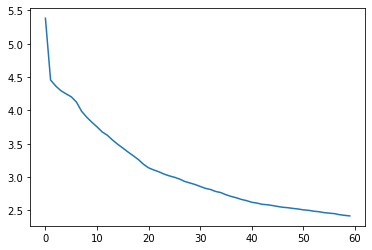

In [55]:
# IGNORE UNLESS RETRAINING

vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)
emb_size = 256
hidden_size = 256
bos_out = stoi_fr['<bos>'] # output <bos> token

model = Seq2SeqModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi_en['<pad>']) # ignore loss from <pad> tokens
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
model = train_seq2seq(train_data, model, opt, loss_fn, num_epochs=60, batch_size=1024, grad_clip=5., print_every=1, 
                      test_data=test_data, teacher_forcing=0.5, show_batches_bar=False, scheduler=scheduler)

In [39]:
# IGNORE UNLESS RETRAINING

torch.save(model.state_dict(), model_path / 'dummy.pth')
model = Seq2SeqModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
model.load_state_dict(torch.load(model_path / 'dummy.pth', map_location=torch.device(device)))

/home/paperspace/miniconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [97]:
# IGNORE UNLESS RETRAINING

def translate(model, english):
    model = model.eval()
    x = [token.text.lower() for token in tokenizer_en(english)]
    x = vocab_en(x)
    x = pad_tokens(x, seq_len, vocab_en.get_stoi())
    x = torch.tensor(x).long().to(device)[None, :]
    yhat = model(x)
    yhat = yhat.argmax(dim=-1).long().detach().cpu().flatten()
    french = [vocab_fr.get_itos()[y] for y in yhat]
    return ' '.join(french).replace('<pad>', '').replace('<eos>', '').replace('<bos>', '').strip()

In [41]:
# IGNORE UNLESS RETRAINING

translate(model, 'Who are you?'), translate(model, 'Stop!'), translate(model, 'Where am I?')

('qui est -ce ?', 'arrête de !', 'où est -ce ? ?')

## BLEU Scores
- BLEU scores (bilingual evaluation understudy scores) are a metric for scoring machine translation model by matching how many ngrams in the predicted translation overlap with the ngrams in one or more ground truth translations.
- For each ngram in the predicted output, the *modified precision* of how many times the ngrams in the prediction appear in each ground truth reference is calculated. The best average of this (against all possible references) over all possible ngrams (up to a specified max n) in the prediction is then returned as the BLEU score.
- Modified precision: Suppose a set of $n$-grams (words) $w$ (for a particular $n$) appears in the prediction $\text{pred}$. Then the modified precision over the set of references is given by the ratio 
$$\text{MP}_{n} = \frac{\sum_{w \in \text{pred}} \text{# times $w$ appears in all references}}{\sum_{w \in \text{pred}} \text{# times $w$ appears in prediction}}.$$
- The BLEU score is then defined as the exponentiated average over all allowed $n$-grams, weighted by a *brevity length* (BP) factor:
$$\text{BLEU Score} = \text{BP} \exp(\langle \text{MP}_{n} \rangle).$$
- The BP factor is meant to penalize the model from outputting shorter translations than the ground truth translation. Let $L$ be the max reference output length, and $\hat L$ be the predicted output length. Then the BP is commonly calculated by
$$\text{BP} = 1 \text{  if  } \hat L > L \text{  else  } \exp \bigg(1-\frac{\hat L}{L} \bigg).$$

In [39]:
yhat = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
y = [[['My', 'full', 'pytorch', 'test'], ['Completely', 'Different']], [['No', 'Match']]]
bleu_score(yhat, y, max_n=1, weights=[1])

0.6666666865348816

In [40]:
def nums_to_text(nums, itos, strip_specials=[]):
    text = [[itos[idx] for idx in num] for num in nums]
    if len(strip_specials) > 0:
        text = [[word for word in doc if word not in strip_specials] for doc in text]
    return text

def text_to_nums(text, stoi, as_tensor=True):
    nums = [[stoi[idx] for idx in doc] for doc in text]
    if as_tensor:
        nums = torch.tensor(nums).long()
    return nums

def predict(X, model, as_text=False, batch_size=1024, strip_specials=[], as_probs=False):
    model = model.eval()
    if as_text:
        X = text_to_nums(X, stoi_en, as_tensor=True).to(device)
    dataloader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=False)
    batches = []
    for x in tqdm(X):
        yhat = model(x[None, :]).detach().to(device)
        if not as_probs:
            yhat = yhat.argmax(dim=-1).long()
        batches.append(yhat)
    Yhat = torch.cat(batches, 0).to(device)
    if as_text:
        Yhat = nums_to_text(Yhat.cpu().numpy().astype(int).tolist(), itos_fr, strip_specials=strip_specials)
    return Yhat

def get_bleu_scores(Yhat, Y, max_n=1, weights=[1]):
    # gotta do this because bleu_score assumes multiple target translations per prediction, not just one
    targets = []
    preds = []    
    for yhat, y in zip(Yhat, Y):        
        preds.append(yhat)
        targets.append([y])        
    return bleu_score(preds, targets, max_n=max_n, weights=weights)

In [41]:
specials = ['<bos>', '<eos>', '<pad>']
X_text = nums_to_text(X_test.cpu().numpy().tolist(), itos_en, strip_specials=[])
Y_text = nums_to_text(Y_test.cpu().numpy().tolist(), itos_fr, strip_specials=specials)
Yhat_text = predict(X_text, model, as_text=True, strip_specials=specials)
get_bleu_scores(Yhat_text, Y_text, max_n=1, weights=[1])

  0%|          | 0/10595 [00:00<?, ?it/s]

0.5782964955210219

In [42]:
idx = 10

print(X_text[idx])
print(Y_text[idx])
print(Yhat_text[idx])

['<bos>', 'will', 'you', 'give', 'me', 'some', 'time', '?', '<eos>', '<pad>', '<pad>', '<pad>']
['me', '<unk>', '-vous', 'du', 'temps', '?']
['me', '<unk>', '-vous', 'de', 'temps', '?']


In [76]:
X_text_train = nums_to_text(X_train.cpu().numpy().tolist(), itos_en, strip_specials=[])
Y_text_train = nums_to_text(Y_train.cpu().numpy().tolist(), itos_fr, strip_specials=specials)
Yhat_text_train = predict(X_text_train, model, as_text=True, strip_specials=specials, device='cuda')
get_bleu_scores(Yhat_text_train, Y_text_train, max_n=1, weights=[1])

0.4768199143434214

## Beam Search
- In a sequence prediction model, the model tries to learn a distribution $p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$. One imagines *sampling* a likely sequence $\hat y_1, \cdots, \hat y_{T'}$ from this joint distribution:
$$(\hat y_1, \cdots, \hat y_{T'}) \sim p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$$
- The naive way of outputing a prediction is a "greedy search". This approach just uses the argmax of each predicted $\hat y_t$ to generate a prediction sequence. This is what is used in training, and most of the time for prediction.
- But most of the time for sequence prediction greedy search doesn't generate the *best* sequence as a whole. Rather, it's prone to overly focus on the earlier sequence elements, causing it to optimize early, not focusing on the whole thing at once.
- Beam search is a way around this. It's an approximate algorithm for finding the best of a set of sequences sampled from a joint distribution, i.e. approximiately finding the *mode* of the joint distribution.
- For seq2seq tasks like machine translation or language modeling, using beam search on the predicted outputs tends to produce better quality translations than naive greedy search (i.e. just using what the model outputs directly).
- Formally, beam search is a heuristic, best-first tree-search algorithm. Given $t=1,\cdots,T'$, output probabilities $p_t \equiv p(y_t|x_{:t}, y_{:t})$, and a *beam-width* $B$:
    - Using $p_0 \equiv p(y_0|x_0)$, sample the top $B$ classes for $\hat y_0$: $(\hat y_0^{(1)},\cdots,\hat y_0^{(B)}) \sim p_0$.
    - Using each $p_1^{(b_0)} \equiv p\big(y_1|x_0, x_1, \hat y_0^{(b_0)}\big)$, sample the top $B$ classes for $\hat y_1$: $(\hat y_0^{(b_0,1)},\cdots,\hat y_0^{(b_0,B)}) \sim p_1^{(b_0)}$.
    - Repeat recursively for each $t=2,\cdots,T'$ to get sampled sequences $\hat y_t^{(b_0,\cdots,b_{t-1})} \sim p_t^{(b_0,\cdots,b_{t-1})} \equiv p\big(y_t|x_0, \cdots, x_t, \hat y_0^{(b_0)}, \cdots, \hat y_{t-1}^{(b_{t-1})}\big)$.
    - Return the sequence of $\big( \hat y_t^{(b_0,\cdots,b_t)} \big)_{t=1,\cdots,T'}$ whose branch in the search tree is the maximum product of probabilities, i.e. the (approximate) mode
    $$(\hat y_1, \cdots, \hat y_{T'}) \approx \text{argmax } \prod_{t=1}^{T'} p(y_t|x_1,\cdots,x_{t-1}, y_0,\cdots, y_{t-1}).$$
- A beam width of $B=1$ reduces to regular greedy search. It's the extra "beams" that enables beam search to consider other likely and possibly better sequences.
- Some refinements to beam search can give improved results:
    - Underflow: Due to numerical underflow, the above product can quickly go to zero for moderately long sequences. To get around this, it's common to instead optimize the equivalent negative log likelihood instead:
    $$(\hat y_1, \cdots, \hat y_{T'}) \approx \text{argmin } \sum_{t=1}^{T'} -\log p(y_t|x_1,\cdots,x_{t-1}, y_0,\cdots, y_{t-1}).$$
    - Length Normalization: For longer sequences, the joint probabilities can be very small. Because of this, beam search tends to prefer shorter sequences. To get around this we can use length normalization. If $J = \sum_{t=1}^{T'} -\log p(y_t|x_1,\cdots,x_{t-1},\hat y_0,\cdots,\hat y_{t-1})$ is the objective function, one can instead optimize instead the scaled objective function for some power $0 \leq \alpha \leq 1$:
    $$J' \equiv \frac{1}{(T')^\alpha}J.$$
    - Beam Width Tuning: Choosing $B$ to be larger will increase the chance of getting the best sequence, but will also increase compute and memory, and analogously for choosing smaller $B$. Typically, one may choose beam widths in the range $B=10-100$ for industry applications, and even higher for research applications.
- As with object detection, where one always applies NMS to model predictions to clean up bounding boxes, with sequence prediction tasks like machine translation, one almost always applies beam search to model predictions to clean up the output quality. Doing error analysis, it can often come down to figuring out whether the model is performing poorly on some examples, or whether beam search is performing poorly. See Andrew Ng's advice video for tips on how to deal with these cases.

In [43]:
# fast pytorch implementation that takes in batches (batch_size, seq_len, vocab_size)
# returns sorted tuple of top beam_width indices (beam_width, batch_size, seq_len) along with their beam_width scores
def beam_search(probs, beam_width=10, return_type=None):
    if not isinstance(probs, torch.Tensor):
        probs = torch.tensor(probs)
    if len(probs.shape) == 2:
        probs = probs[None, :]
        
    batch_size, seq_len, _ = probs.shape
    log_probs = probs.log()
    log_prob, indices = log_probs[:, 0, :].topk(beam_width, sorted=True)
    indices = indices.unsqueeze(-1)
    for i in range(1, seq_len):
        log_prob = log_prob.unsqueeze(-1) + log_probs[:, i, :].unsqueeze(1).repeat(1, beam_width, 1)
        log_prob, idx = log_prob.reshape(batch_size, -1).topk(beam_width, sorted=True)
        indices = torch.cat([indices, idx.unsqueeze(-1)], dim=-1)
    
    indices = indices.long().cpu()
    scores = -log_prob.float().cpu()
    if return_type == 'list':
        indices = indices.numpy().tolist()
        scores = scores.numpy().tolist()
    return indices, scores
    
# very slow python implementation
# uses NLL implementation, so mins score = NLL = -log(prob)
def beam_search_python(probs, beam_width=10):
    seqs = [[[], 0]]
    # walk over each step in probs
    for prob in tqdm(probs):
        all_candidates = []
        # expand each current candidate
        for i in range(len(seqs)):
            seq, score = seqs[i]
            for j in range(len(prob)):
                candidate = [seq + [j], score - np.log(prob[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda row: row[1], reverse=False)
        # select beam_width best [seq, score] pairs by min score
        seqs = ordered[:beam_width]
    return seqs

In [45]:
Yhat = predict(X_test, model, as_probs=True, batch_size=1028)
Yhat.shape

  0%|          | 0/10595 [00:00<?, ?it/s]

torch.Size([10595, 12, 5000])

In [51]:
i = 101
y = Y_test[i].cpu()
yhat = Yhat[i].detach().cpu().sigmoid().numpy().tolist()
indices, scores = beam_search(yhat, beam_width=10, return_type='list')
print(indices[0])
print(scores)

[[0, 76, 202, 42, 19, 429, 4, 1, 1, 1, 1, 1], [18, 52, 5202, 36, 5019, 5429, 5004, 5001, 5001, 5001, 5001, 5001], [76, 123, 10202, 5042, 10019, 10429, 10004, 10001, 10001, 10001, 10001, 10001], [52, 18, 15202, 5036, 15019, 15429, 15004, 15001, 15001, 15001, 15001, 15001], [39, 202, 20202, 19, 20019, 52, 20004, 20001, 20001, 4, 20001, 20001], [123, 98, 42, 5019, 25019, 20429, 25004, 25001, 4, 20001, 4, 25001], [5, 17, 5042, 10042, 30019, 5052, 30004, 30001, 25001, 5004, 25001, 4], [1451, 7, 10042, 10036, 35019, 10052, 35004, 35001, 30001, 25001, 30001, 30001], [160, 5076, 25202, 10019, 40019, 25429, 40004, 40001, 5004, 30001, 5004, 35001], [286, 5052, 30202, 15042, 45019, 15052, 45004, 45001, 35001, 10004, 35001, 40001]]
[[6.353987555485219e-05, 6.437434058170766e-05, 6.497038702946156e-05, 6.580485205631703e-05, 6.771221524104476e-05, 6.783142453059554e-05, 6.818905239924788e-05, 6.830849451944232e-05, 6.854668026790023e-05, 6.866588955745101e-05]]


In [62]:
def clean_sentence(sentence, specials):
    for special in specials:
        sentence = sentence.replace(special, '')
    return sentence.strip()

greedy_search_sentence = ' '.join([itos_fr[idx] for idx in np.argmax(yhat, axis=1).tolist()])
beam_search_sentence = ' '.join([itos_fr[idx] for idx in indices[0][0]])
ground_truth_sentence = ' '.join([itos_fr[idx] for idx in y])

print(f'greedy search: {clean_sentence(greedy_search_sentence, specials)}')
print(f'beam search: {clean_sentence(beam_search_sentence, specials)}')
print(f'ground truth: {clean_sentence(ground_truth_sentence, specials)}')

greedy search: ma mère m' a donné .
beam search: ma mère m' a donné .
ground truth: ma mère m' a appelé .


## Attention Models
- Vanilla seq2seq models tend not to work as well for longer sequences, e.g. 30+ word sequences. This is in essence because they have to remember the entire input to pass into the decoder and decide what the output should be. 
- Attention models get around this problem by using a learned "attention layer" to learn the probabilities of any one input affecting that output. That way, the decoder can only focus on a specific range of inputs (the local context), and not the whole sequence.
- Example: Consider the translation `Jane visite l'Afrique en septembre` -> `Jane visits Africa in September`. In predicting the output token `Africa`, the model will probably want to look most around the word `l'Afrique` of the input. So maybe the input tokens should be weighted as below. That is, the model should focus 90% of its weight on the word `l'Afrique` when predicting the output word `Africa`.
|Word|Attention Weights - `Africa`|
|---|---|
|Jane | 0.2 |
|visite | 0.6 |
|l'Afrique | 0.9 |
|en | 0.1 |
|septembre | 0.1 |
- More formally, consider a seq2seq model with encoder hidden activations $h_1^{(enc)},\cdots,h_T^{(enc)}$ and decoder activations $h_1^{(dec)},\cdots,h_{T'}^{(dec)}$. Let $a_{t',t}$ be the attention weights that output $t'$ is paying to input $t$. Define the context vector for $t'$ to be the matrix product $c_{t'} \equiv a_{t',t} h_{t}^{(enc)}$. Then the input to the decoder will be the elementwise product $y_{t'} \ast c_{t'}$.
- To get the matrix of params $a_{t',t}$, we use another linear layer to compute a set of outputs $e_{t',t}$ given by
$$e_{t',t} = W_e [h_{t'-1}^{(dec)}, h_t^{(enc)}] + b_e.$$
The attention weights are then given by passing $e_{t',t}$ through a softmax to get probabilities:
$$a_{t',t} = \text{softmax}(e_{t',t}) = \frac{\exp(e_{t',t})}{\sum_t \exp(e_{t',t})}.$$
- Note that attention is quadratic time in the sequence lengths. Since we must calculate each $a_{t',t}$, that gives $O(T'T)$ computations.
- It's common to visualize the matrix of attention weights by using a heatmap. This can be used to visually show how much each output $t'$ is influenced by each input $t$.

In [78]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(emb_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
    
    def forward(self, x, h=None):
        x = self.emb(x)
        x = self.dropout(x)
        x = self.relu(x)
        x, h = self.rnn(x, h)
        return x, h
    
class AttentionDecoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, seq_len=seq_len, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(output_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(hidden_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.seq_len = seq_len
        self.attn = nn.Linear(emb_size + hidden_size, seq_len)
        self.attn_combine = nn.Linear(emb_size + hidden_size, hidden_size)
    
    def forward(self, y, enc_out, h=None, seq_len=1):       
        y = self.emb(y)
        y = self.dropout(y)
        
        h_rep = h.repeat(seq_len, 1, 1).permute(1, 0, 2)
        attn = self.attn(torch.cat((y, h_rep), 2)).softmax(dim=2) # quadratic time
        c = torch.bmm(attn, enc_out)
        yc = torch.cat((y, c), 2)
        y = self.attn_combine(yc)
        
        y = self.relu(y)
        y, h = self.rnn(y, h)
        y = self.fc(y)
        return y, h, attn
    
class AttentionModel(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size, n_layers=1, bos=0, rnn=nn.GRU, dropout=0.5,
                 seq_len=seq_len):
        super().__init__()
        self.encoder = Encoder(input_size, emb_size, hidden_size, n_layers, rnn=rnn, dropout=dropout)
        self.decoder = AttentionDecoder(output_size, emb_size, hidden_size, n_layers, rnn=rnn, dropout=dropout, 
                                        seq_len=seq_len)
        self.output_size = output_size
        self.bos = bos
    
    def forward(self, X, h=None, Y=None, teacher_forcing=0, device=device, store_attention=False):
        attns = []
        enc_out, h = self.encoder(X, h)
        seq_len, batch_size = X.shape[1], X.shape[0]
        Y = Y.permute(1, 0) if Y is not None else None
        Yhat = torch.empty(seq_len, batch_size, self.output_size)
        y_prev = torch.tensor([self.bos] * batch_size).reshape(batch_size, 1).to(device)
        for i in range(seq_len):
            y_out, h, attn = self.decoder(y_prev, enc_out, h, seq_len=1)
            y_prev = y_out.argmax(dim=-1).detach()
            y_prev = Y[i][:, None] if np.random.rand() < teacher_forcing else y_prev
            Yhat[i] = y_out.permute(1, 0, 2)
            attns.append(attn)
        Yhat = Yhat.permute(1, 0, 2).to(device)
        if store_attention:
            attns = torch.cat(attns, 1).to(device)
            return Yhat, attns
        else:
            return Yhat

In [31]:
input_size = 1000
output_size = 1000
emb_size = 50
seq_len = seq_len
hidden_size = 100
batch_size = 128
n_layers = 1

x = torch.randint(0, input_size, size=(batch_size, seq_len)).to(device)
enc = Encoder(input_size, emb_size, hidden_size, n_layers, rnn=nn.GRU, dropout=0.5).to(device)
enc_out, h = enc(x, h=None)

y = torch.randint(0, output_size, size=(batch_size, seq_len)).long().to(device)
dec = AttentionDecoder(output_size, emb_size, hidden_size, n_layers, seq_len=seq_len, rnn=nn.GRU, 
                       dropout=0.5).to(device)
dec_out, h, a = dec(y, enc_out, h=h, seq_len=seq_len)

model = AttentionModel(input_size, emb_size, hidden_size, output_size, n_layers=1, bos=0, rnn=nn.GRU, dropout=0.5,
                       seq_len=seq_len).to(device)
yhat = model(x).to(device)
y.shape, yhat.shape

(torch.Size([128, 12]), torch.Size([128, 12, 1000]))

  0%|          | 0/80 [00:00<?, ?it/s]

epoch: 0     train loss: 5.3734   test loss: 4.7889
epoch: 1     train loss: 4.4383   test loss: 4.6119
epoch: 2     train loss: 4.3375   test loss: 4.5832
epoch: 3     train loss: 4.2574   test loss: 4.5363
epoch: 4     train loss: 4.2039   test loss: 4.5397
epoch: 5     train loss: 4.1566   test loss: 4.4602
epoch: 6     train loss: 4.0584   test loss: 4.377 
epoch: 7     train loss: 3.9673   test loss: 4.2584
epoch: 8     train loss: 3.8758   test loss: 4.1296
epoch: 9     train loss: 3.7484   test loss: 4.0175
epoch: 10    train loss: 3.6785   test loss: 3.9434
epoch: 11    train loss: 3.6051   test loss: 3.8184
epoch: 12    train loss: 3.5196   test loss: 3.7155
epoch: 13    train loss: 3.4512   test loss: 3.6431
epoch: 14    train loss: 3.3952   test loss: 3.5746
epoch: 15    train loss: 3.333    test loss: 3.5028
epoch: 16    train loss: 3.2599   test loss: 3.4289
epoch: 17    train loss: 3.1961   test loss: 3.3533
epoch: 18    train loss: 3.123    test loss: 3.2965
epoch: 19   

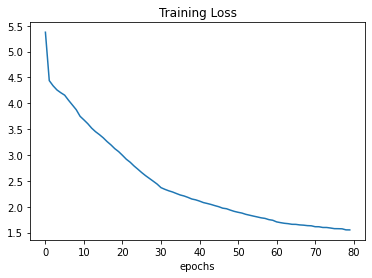

In [32]:
vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)
emb_size = 256
hidden_size = 256
bos_out = stoi_fr['<bos>'] # output <bos> token

model = AttentionModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi_en['<pad>'])
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.5)
model = train_seq2seq(train_data, model, opt, loss_fn, num_epochs=80, batch_size=1024, grad_clip=5., print_every=1, 
                      test_data=test_data, teacher_forcing=0.5, show_batches_bar=False, scheduler=scheduler)

In [79]:
# torch.save(model.state_dict(), model_path / 'checkpoint.pth')
# torch.save(vocab_en, model_path / 'vocab_en.pth')
# torch.save(vocab_fr, model_path / 'vocab_fr.pth')

model = AttentionModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
model.load_state_dict(torch.load(model_path / 'checkpoint.pth', map_location=torch.device(device)))

vocab_en = torch.load(model_path / 'vocab_en.pth')
vocab_fr = torch.load(model_path / 'vocab_fr.pth')

In [63]:
# fast pytorch implementation that takes in batches (batch_size, seq_len, vocab_size)
# returns sorted tuple of top beam_width indices (beam_width, batch_size, seq_len) along with their beam_width scores
def beam_search(probs, beam_width=10, return_type=None):
    if not isinstance(probs, torch.Tensor):
        probs = torch.tensor(probs)
    if len(probs.shape) == 2:
        probs = probs[None, :]
        
    batch_size, seq_len, _ = probs.shape
    log_probs = probs.log()
    log_prob, indices = log_probs[:, 0, :].topk(beam_width, sorted=True)
    indices = indices.unsqueeze(-1)
    for i in range(1, seq_len):
        log_prob = log_prob.unsqueeze(-1) + log_probs[:, i, :].unsqueeze(1).repeat(1, beam_width, 1)
        log_prob, idx = log_prob.reshape(batch_size, -1).topk(beam_width, sorted=True)
        indices = torch.cat([indices, idx.unsqueeze(-1)], dim=-1)
    
    indices = indices.long().cpu()
    scores = -log_prob.float().cpu()
    if return_type == 'list':
        indices = indices.numpy().tolist()
        scores = scores.numpy().tolist()
    return indices, scores

def translate(model, english, use_beam_search=True, specials=specials):
    model = model.eval()
    x = [token.text.lower() for token in tokenizer_en(english)]
    x = vocab_en(x)
    x = pad_tokens(x, seq_len, vocab_en.get_stoi())
    x = torch.tensor(x).long().to(device)[None, :]
    yhat = model(x).detach().cpu()
    if use_beam_search:
        indices, scores = beam_search(yhat.softmax(dim=-1), beam_width=10, return_type='list')
        pred = indices[0][0]
    else:
        pred = yhat.argmax(dim=-1).long().flatten()
    french = ' '.join([vocab_fr.get_itos()[idx] for idx in pred])
    french = clean_sentence(french, specials).strip()
    return french

translate(model, 'Who are you?'), translate(model, 'Stop!'), translate(model, 'Where am I?')

('qui qui -vous ?', 'arrête !', 'où est -ce que ?')

In [64]:
specials = ['<bos>', '<eos>', '<pad>']
X_text = nums_to_text(X_test.cpu().numpy().tolist(), itos_en, strip_specials=[])
Y_text = nums_to_text(Y_test.cpu().numpy().tolist(), itos_fr, strip_specials=specials)
Yhat_text = predict(X_text, model, as_text=True, strip_specials=specials)
get_bleu_scores(Yhat_text, Y_text, max_n=1, weights=[1])

  0%|          | 0/10595 [00:00<?, ?it/s]

0.5782964955210219

In [71]:
translate(model, 'What is going on in the world today?')

"quelle va passe au le le aujourd'hui ?"

In [107]:
x = X_test[:10]
yhat, attns = model(x, store_attention=True)
x, yhat, attns = x.cpu(), yhat.detach().cpu().argmax(-1), attns.detach().cpu()
x.shape, yhat.shape, attns.shape

(torch.Size([10, 12]), torch.Size([10, 12]), torch.Size([10, 12, 12]))

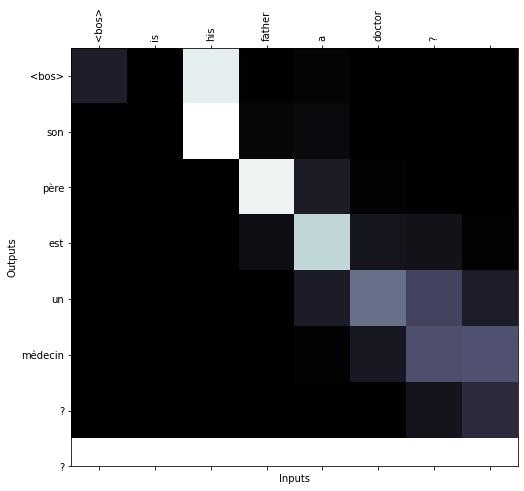

In [142]:
def viz_attention(input, output, attn, itos_in, itos_out, specials=specials):
    import matplotlib.ticker as ticker
    
    in_words = [itos_in[idx] for idx in input]
    out_words = [itos_out[idx] for idx in output]
    in_words = [word for word in in_words if word not in specials]
    out_words = [word for word in out_words if word not in specials]
    
    grid = attn.numpy()[:len(in_words), :len(out_words)]
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(grid, cmap='bone')
    # fig.colorbar(cax)

    ax.xaxis.set_ticks(range(len(in_words)))
    ax.yaxis.set_ticks(range(len(out_words)))
    ax.set_xticklabels(in_words, rotation=90)
    ax.set_yticklabels(out_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_xlabel('Inputs')
    ax.set_ylabel('Outputs')

    plt.show()    

idx = 3
viz_attention(x[idx], yhat[idx], attns[idx], itos_en, itos_fr, specials=['<eos>', '<pad>'])

## Transformers